In [1]:
using DataFrames
using ControlSystemsBase
using Statistics
using Distributions
using Plots
using GLM
using Serialization

using RealTimeScheduling
using ControlTimingSafety

push!(LOAD_PATH, "../lib")
using Experiments
using Benchmarks
using ControlVariates

## SHT

Questions regarding sample size and prior belief for SHT is discussed in this section. The key points are summarized below:

|   B    | type-I error |   c    |  Original K  |    K    |  Original K / K  |
| ------ | ------------ | ------ | ------------ | ------- | ---------------- |
| 100    | 0.497        | 0.99   | 459.20       | 69.47   | 6.61             |
| 100    | 0.497        | 1-1e-5 | 4.62e5       | 99.95   | 4617.38          |
| 4.15e5 | 0.000238     | 0.99   | 1287.12      | 829.94  | 1.55             |
| 4.15e5 | 0.000238     | 1-1e-5 | 1.2936e6     | 1.639e5 | 7.89             |


**Questions regarding prior belief**

The issue about equal prior belief for $H_0$ and $H_1$: recall that given deviation upper bound $d_{ub}$, confidence level $c$, and the set of all possible samples $X$, the two hypothesis are defined as follows:
$$
\newcommand{\dev}{\texttt{Deviation}}
H_0: Pr(\dev(x) < d_{ub} | x \in X) < c \\
H_1: Pr(\dev(x) < d_{ub} | x \in X) > c
$$
assuming that the sample $x$ is drawn uniformly from the set $X$.
In the SHT paper, the Bayes Factor $B$ is used to compute $K$, the number of required samples to draw to give 

\begin{align}
\frac{Pr(H_1)}{Pr(H_0)} B &= \frac{Pr(H_1|Data)}{Pr(H_0|Data)} \\
\frac{Pr(H_1)}{Pr(H_0)} B &= \frac{\frac{Pr(Data|H_1)Pr(H_1)}{Pr(Data)}}{\frac{Pr(Data|H_0)Pr(H_0)}{Pr(Data)}} \\
B &= \frac{Pr(Data|H_1)}{Pr(Data|H_0)} \\
B &= \frac{\int_c^1 P(Data|\theta=q, H_1) f_{\theta|H_1}(q)dq}
          {\int_0^c P(Data|\theta=q, H_0) f_{\theta|H_0}(q)dq} \\
B &= \frac{\int_c^1 P(Data|\theta=q, H_1) \frac{1}{1-c} dq}
          {\int_0^c P(Data|\theta=q, H_0) \frac{1}{c} dq} \\
B &= \frac{c \int_c^1 q^K dq}
          {(1-c) \int_0^c q^K dq} \\
\frac{1-c}{c} B &= \frac{\int_c^1 q^K dq}
                        {\int_0^c q^K dq} \\
K &= -\log_c(\frac{1-c}{c}B + 1)
\end{align}

A factor of $\frac{1-c}{c}$ is missing from within the logarithm function, and will cause more samples to be drawn than intended.

Traditionally, a Bayes factor $B$ of $100$ is considered extreme evidence favoring the alternative hypothesis. However, the paper we are based on states the type-I error is expressed by
$$
err = \frac{c}{c(1-c)B}
$$
Which is ~$.497$ when $B=100$, and ~$.000238$ when $B=4.15*10^5$:

In [ ]:
let
    c = 0.99
    B = 100
    e = c/(c+(1-c)*B)
    B_og = 4.15e5
    e_og = c/(c+(1-c)*B_og)
    @info "Comparison of error with B=100 versus B=4.15e5: " e e_og
end

Next, we compare the original $K$ values from the paper versus the new $K$ values with the missing factor.

In [ ]:
let
    B = 4.15e5
    c = [0.9, 0.99, 0.999, 0.9999, 1-1e-5, 1-1e-10, 1-1e-15]
    K_og = -log.(c, B + 1)
    K    = -log.(c, (1 .- c) ./ c * B .+ 1)

    [c K_og K K_og./K]
end

Finally we compare the $K$ values with $B=100$

In [ ]:
let
    B = 100
    c = [0.9, 0.99, 0.999, 0.9999, 1-1e-5, 1-1e-10, 1-1e-15]
    K_og = -log.(c, B + 1)
    K    = -log.(c, (1 .- c) ./ c * B .+ 1)

    [c K_og K K_og./K]
end

## Experiments

Setting parameters for the experiment:

In [2]:
B = 4.15e5
H = 100
q = 0.99
period = 0.02
sys = benchmarks[:F1T]
x0 = 1.
u0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u0]

# Construct an automaton with no constraint
a = hold_kill(c2d(sys, period), delay_lqr(sys, period))

Automaton(AbstractMatrix{Float64}[[1.0 0.12999999999999998 0.02559055118110236; 0.0 1.0 0.39370078740157477; -0.582977923541146 -0.9271753376618662 -0.3501109341069651], [1.0 0.12999999999999998 0.02559055118110236; 0.0 1.0 0.39370078740157477; 0.0 0.0 1.0]], Union{Missing, Int64}[1 1], Union{Missing, Int64}[1 2], 1, [1.0 0.0 0.0])

### System Dynamics


Open-loop stable system (RC network):
$$
\mathbf{\dot{x}}(t) = \begin{bmatrix} -6.0 & 1.0 \\ 0.2 & -0.7 \end{bmatrix} \mathbf{x}(t) +
\begin{bmatrix} 5.0 \\ 0.5 \end{bmatrix} u(t)
$$
where
$$
\mathbf{x}(t) = \begin{bmatrix} x_1(t) \\ x_2(t) \end{bmatrix}
$$
is the system state and $u(t)$ is the control input.

We also have a open-loop unstable system (F1 tenth):
$$
\mathbf{\dot{x}}(t) = \begin{bmatrix} 0 & 6.5 \\ 0 & 0 \end{bmatrix} \mathbf{x}(t) +
\begin{bmatrix} 0 \\ 19.685 \end{bmatrix} u(t)
$$

In [ ]:
benchmarks[:RCN], benchmarks[:F1T]

### Simulations

We first sample sequences of length H=100 where each deadline has p=0.9 chance to hit.

In [ ]:
sp = SamplerPWCET(0.9, 100)
mean([sum(rand(sp)) for i in 1:100])

Generate 100k samples:

In [ ]:
n = 100_000
@time res99 = generate_samples(a, z0, 0.99, n)
@time res90 = generate_samples(a, z0, 0.90, n)
@time res50 = generate_samples(a, z0, 0.50, n)
@time res10 = generate_samples(a, z0, 0.10, n)

Save samples to disk

In [ ]:
using Serialization
@time serialize("../data/res99-100k.jls", res99)
@time serialize("../data/res90-100k.jls", res90)
@time serialize("../data/res50-100k.jls", res50)
@time serialize("../data/res10-100k.jls", res10)

### Analyze Simulated Samples

In [3]:
suffix = "1000000"
res99 = deserialize("../data/res99-$suffix.jls")
res90 = deserialize("../data/res90-$suffix.jls")
res50 = deserialize("../data/res50-$suffix.jls")
res10 = deserialize("../data/res10-$suffix.jls");

Generate plots of deviation versus control variables for the first 7 periods.

1000000


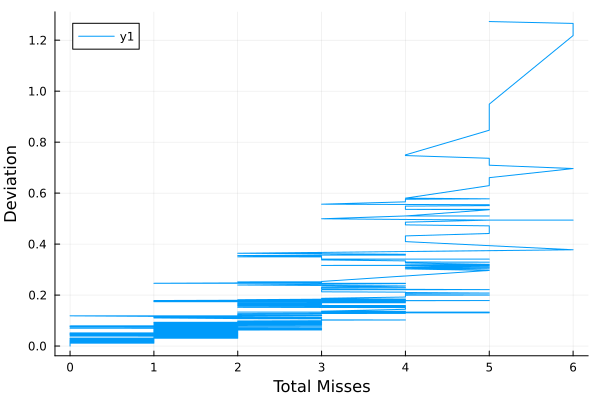

In [8]:
res = res90
devs = map(x -> x[2], res)
σs = map(x -> x[1], res)
σs3 = map(x -> x[1:3], σs)
σs5 = map(x -> x[1:5], σs)
σs7 = map(x -> x[1:7], σs)
σsx = map(x -> x[1:10], σs)

p1 = plot(devs, (1:length(res)) ./ length(res), 
    xlabel="Deviation", ylabel="Probability", label="cdf", title="p=0.10")
p2 = plot(missrow.(σs7), devs,
    ylabel="Deviation", xlabel="Consecutive Misses", label="p=0.9")
p3 = plot(misstotal.(σs7), devs,
    ylabel="Deviation", xlabel="Total Misses")
p4 = plot(missfirst.(σs7), devs,
    ylabel="Deviation", xlabel="First Miss")
for c in [0.99]
    dev = devs[round(Int64, length(res)*c)]
    scatter!(p1, [dev], [c], label="99th quantile = $(round(dev, sigdigits=3))")
end
println(length(res))
savefig(p1, "cdf.pdf")
savefig(p2, "cv_cm_7.pdf")
savefig(p3, "cv_tm_7.pdf")
savefig(p4, "cv_fm_7.pdf")
display(p3)

Print results for 99% and 100% quantile in each sample, along with the ratio between two quantiles.

In [5]:
for (res, p) in [(res99, 0.99), (res90, 0.9), (res50, 0.5), (res10, 0.1)]
    devs = map(x -> x[2], res)
    p99 = round(devs[round(Int64, length(devs)*0.99)], sigdigits=3)
    p100 = round(devs[end], sigdigits=3)
    println("p=$p\t99%=$p99\t100%=$p100\tp100/p99=$(p100/p99)")
end

p=0.99	99%=0.165	100%=0.364	p100/p99=2.206060606060606
p=0.9	99%=0.331	100%=1.27	p100/p99=3.836858006042296
p=0.5	99%=1.66	100%=18.6	p100/p99=11.204819277108435
p=0.1	99%=36300.0	100%=198000.0	p100/p99=5.454545454545454


### Deviation Estimation with SHT

Conclusion: min of 50 runs with SHT is close to 99th percentile in large random samples, with lower p values leading to more overestimation compared to 99th percentile; max of 50 runs is closer to 100th percentile, but underestimates.

In [7]:
for p in [0.1, 0.5, 0.9, 0.99]
    mind = Inf
    maxd = 0.
    sample_t = 0
    devest_t = 0
    for i in 1:50
        t = time()
        sp = SamplerPWCET(p, 100)
        sample_t += time() - t
        
        t = time()
        dub = estimate_deviation(a, sp, z0, q, B)
        devest_t += time() - t

        mind = min(mind, dub)
        maxd = max(maxd, dub)
    end
    @info p sample_t devest_t mind maxd maxd/mind
end

┌ Info: 0.1
│   sample_t = 4.76837158203125e-6
│   devest_t = 18.42928910255432
│   mind = 63081.78583606427
│   maxd = 162052.8839993246
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18
┌ Info: 0.5
│   sample_t = 3.814697265625e-6
│   devest_t = 19.37014889717102
│   mind = 2.4701570944702076
│   maxd = 16.83713655921366
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18
┌ Info: 0.9
│   sample_t = 5.0067901611328125e-6
│   devest_t = 15.322127342224121
│   mind = 0.36408893924524055
│   maxd = 0.9491345984884901
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18
┌ Info: 0.99
│   sample_t = 6.198883056640625e-6
│   devest_t = 11.982646465301514
│   mind = 0.1786396896500381
│   maxd = 0.36408893924524055
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18


### Likelihood Ratio Test

\begin{align}
\lambda_{LR} &=\frac{\sup_{\theta_0\in\Theta_0}{L}(\theta_0)}{\sup_{\theta\in\Theta}L(\theta)} \\
&= \frac{\binom{n}{x} \theta_0^x (1-\theta_0)^{n-x}}{\binom{n}{x} \theta^x (1-\theta)^{n-x}} \\
&= \frac{\theta_0^x (1-\theta_0)^{n-x}}{ \theta^x (1-\theta)^{n-x}} \\
&= \left(\frac{\theta_0}{\theta}\right)^x + \left(\frac{1-\theta_0}{1-\theta}\right)^{n-x}
\end{align}

\begin{align}
&= -2 \ln \left[ \frac{\binom{n}{k} \theta_0^x (1-\theta_0)^{n-x}}{\binom{n}{k} \theta_1^x (1-\theta_1)^{n-x}} \right] \\
&= -2 \ln \left[ \frac{\theta_0^x (1-\theta_0)^{n-x}}{ \theta_1^x (1-\theta_1)^{n-x}} \right] \\
&= -2 (x \ln \frac{\theta_0}{\theta_1} + (n-x) \ln \frac{1-\theta_0}{1-\theta_1})
\end{align}

In [ ]:
lr_test(0.99, 100, 99)

In [ ]:
lr_test(0.99, 830, 830)

In [ ]:
lr_test_2(0.99, 8782, 0.005)

In [ ]:
lr_test_2(0.99, 46500, 0.002)

Likelihood ratio with null hypothesis: true $\theta$ is within a range (e.g., $[0.899, 0.991]$) instead of $\theta>0.99$ vs $\theta<0.99$.

In [ ]:
err = 0.000238497

In [ ]:
n = 8782
for p in [0.99, 0.90, 0.50, 0.10]
    mind = Inf
    maxd = 0.
    devest_t = 0
    for i in 1:50
        t = time()
        lrres = generate_samples(σ p, n)
        x = round(Int64, n * 0.99)
        dev = lrres[x][2]
        devest_t += time() - t
        
        mind = min(mind, dev)
        maxd = max(maxd, dev)
    end
    @info p devest_t mind maxd maxd/mind
end

### Control Variate

In [9]:
# Using values from simulation

res = res90
devs = map(x -> x[2], res)
σs = map(x -> x[1], res)
σs5 = map(x -> x[1:10], σs)

X = devs
Y = missrow.(σs)
Y5 = missrow.(σs5)
Z = misstotal.(σs)
Z5 = misstotal.(σs5)
U = missfirst.(σs)

data = DataFrame(Dev=X, CM=Y, TM=Z, FM=U, CM5=Y5, TM5=Z5)

ols_y = lm(@formula(Dev ~ CM5), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Dev ~ 1 + CM5

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.00350164  8.08529e-5  -43.31    <1e-99  -0.00366011  -0.00334317
CM5           0.0565896   8.36878e-5  676.20    <1e-99   0.0564256    0.0567536
────────────────────────────────────────────────────────────────────────────────

In [8]:
ols_z = lm(@formula(Dev ~ TM5), data)

UndefVarError: UndefVarError: `data` not defined

In [ ]:
ols_u = lm(@formula(Dev ~ FM), data)

In [ ]:
FcvW(0.1566, 10, res90, misstotal)

In [ ]:
x = inverse_fcv(0.99, 10, res90, misstotal)

In [ ]:
res90[99000][2]

In [ ]:
confidence_interval(0.1, x, 0.01, 0.99, 9.997078246122365, res90, missfirst)

In [ ]:
Psi2_cv(x, 0.99, res50, misstotal)

In [ ]:
calculate_mean_miss(missfirst,res90)

In [ ]:
(100*0.9^101-101*0.9^100+1)/0.1

In [ ]:
x=[1,2,3]
y=x[1:2]

In [ ]:
res = generate_samples(a, z0, 0.9, 1000)
res2 = Vector{Tuple{BitVector, Float64}}(undef, 1000)
i = 1
for(σ, deviation) in res
    σs5 =  σ[1:10]
    res2[i] = (σs5, deviation)
    i += 1
end
i = 1
res2

In [ ]:
dev_CV = inverse_fcv(0.99, 1, res2, misstotal)
dev_NMC = res[990][2]
print(dev_NMC,dev_CV)

In [ ]:
result = Vector{BitVector}(undef, 0)
    previous = [[1],[0]]
    for vector in previous
        push!(vector, 1)
        push!(result, vector)
    end
result

In [14]:
σ5 = map(x -> (x[1][1:5], x[2]), res99)
σ = Dict(
    "5" => map(x -> (x[1][1:5], x[2]), res99)
)
σ["5"]

1000000-element Vector{Tuple{BitVector, Float64}}:
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ⋮
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)

In [ ]:
n = bin_list(10)
p = 0.9
values = map(vec -> missrow(vec) * p^(10 - misstotal(vec)) * (1 - p)^misstotal(vec), n)
total = sum(values)

In [ ]:
allmind['missrow'] = 5
for cv in cvs:
    mind = Inf
    maxd = 0
    for sampleset in samplesets:
        qestimate = estimate(cv, sampleset)
        mind = min(mind, qestimate)
        maxd = max(maxd, qestimate)
        @info "CV function: $cv" mind maxd


In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)
    res2 = Vector{Tuple{BitVector, Float64}}(undef, n)
    k = 1
    for(σ, deviation) in res
        σs5 =  σ[1:10]
        res2[k] = (σs5, deviation)
        k += 1
    end
    k = 1

    dev_CV = inverse_fcv(0.99, 0.7395658498000013, res2, missrow)
    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)
    res2 = Vector{Tuple{BitVector, Float64}}(undef, n)
    k = 1
    for(σ, deviation) in res
        σs5 =  σ[1:10]
        res2[k] = (σs5, deviation)
        k += 1
    end
    k = 1

    dev_CV = inverse_fcv(0.99, (10*0.9^11-11*0.9^10+1)/0.1, res2, missfirst)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)
    res2 = Vector{Tuple{BitVector, Float64}}(undef, n)
    k = 1
    for(σ, deviation) in res
        σs5 =  σ[1:10]
        res2[k] = (σs5, deviation)
        k += 1
    end
    k = 1

    dev_CV = inverse_fcv(0.99, 1, res2, misstotal)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)

    dev_CV = inverse_fcv(0.99, (100*0.9^101-101*0.9^100+1)/0.1, res, missfirst)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)

    dev_CV = inverse_fcv(0.99, (100*0.9^101-101*0.9^100+1)/0.1, res, missfirst)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
for p in [0.1, 0.5, 0.9, 0.99]
    mind_NMC = Inf
    maxd_NMC = 0
    mind_CV = Inf
    maxd_CV = 0
    for i in 1:50
        n = 10000
        res = generate_samples(a, z0, p, n)

        dev_CV = inverse_fcv(0.99, 100*(1-p), res, misstotal)

        dev_NMC = res[Int(n*0.99)][2]

        mind_CV = min(mind_CV, dev_CV)
        maxd_CV = max(maxd_CV, dev_CV)
        mind_NMC = min(mind_NMC, dev_NMC)
        maxd_NMC = max(maxd_NMC, dev_NMC)

    end
    @info p mind_CV maxd_CV mind_NMC maxd_NMC
end

## Analytic solutions

### Mean of first miss

The probability $P(n)$ of first miss occurs in position $n$ in a string of length $H (H \ge n)$ with hit probablity $a (0\le a\le1)$ is:
$$
P(n)=a^{n-1}\cdot (1-a)
$$
The mean value of the position of first miss $M(H)$ can be expressed as:
$$
\begin{align}
M(H)&=\sum^{H}_{n=1}nP(n)\\
&=(1-a)\sum^{H}_{n=1}na^{n-1}\\
&=(1-a)\sum^{H}_{n=1}\frac{d}{da}a^n\\
&=(1-a)\frac{d}{da}\sum^{H}_{n=1}a^n\\
&=(1-a)\frac{d}{da}\frac{a(1-a^H)}{1-a}\\
&=\frac{Ha^{H+1}-(H+1)a^H+1}{1-a}
\end{align}
$$

In [ ]:
a = 0.9
H = 100

first_miss_mean = (H*a^(H+1) - (H+1)*a^H + 1) / (1-a)

### Mean of total misses
The probability $P(n,H)$ of $n$ total misses occurs  in a string of length $H (H \ge n)$ with hit probablity $a (0\le a\le1)$ is:
$$
P(n,H)= {H \choose n}a^{H-n}(1-a)^n
$$
Let $1-a=x$.
The mean value of the total number of misses $M(H)$ can be expressed as:
$$
\begin{align}
M(H)&=\sum^{H}_{n=1}nP(n,H)\\
&=\sum^{H}_{n=1}n{H \choose n}a^{H-n}x^n\\
&=x\sum^{H}_{n=1}\frac{d}{dx}{H \choose n}a^{H-n}x^n\\
&=x\frac{d}{dx}(a+x)^H\\
&=H(1-a)
\end{align}
$$

In [ ]:
a = 0.9
H = 100

total_miss_mean = H*(1-a)

### Mean of consecutive misses
The probability $P(n,H)$ of $n$ consecutive misses occurs  in a string of length $H (H \ge n)$ with hit probablity $a (0\le a\le1)$ is:
$$
P(n,H)= 
$$

We calculate the expected value of # of longest consecutive misses in a sequence by leveraging two matrices with dynamic programming. Assuming each deadline has a chance of $p$ being met,
$$
T[m, k] = P(\text{a sequence of length $m$ has a longest consecutive misses of $k$})
$$ and 
$$
C[m, k] = \sum_{i = 0}^k T[m, i]
$$

In [ ]:
@time T, C = calculate_missrow_prob(10, 0.9)

In [ ]:
T

In [ ]:
sum(map(x -> x*T[10, x], 0:10))

## MissRow Constraints


In [ ]:
function devubrow(miss::Integer, sysd::AbstractStateSpace{<:Discrete},
    K::AbstractMatrix{<:Real}, z_0::AbstractVecOrMat, d_max::Real, n::Integer,
    H::Integer, nominal::Union{Matrix{<:Real}, Nothing}=nothing)
    @boundscheck nominal === nothing || size(nominal, 1) == H+1 || throw(ArgumentError("nominal and H mismatch"))
    if miss === 0 && nominal === nothing
        return 0.
    end
    constraint = MissRow(miss)
    a = hold_kill(sysd, K, constraint)
    reachable = bounded_runs_iter(a, z_0, n, H)
    if size(reachable, 1) != H+1
        @info "Size mismatch"
        return d_max
    end
    # @info "Data" meet window size(reachable, 1) argmax(deviation(a, z_0, reachable))
    maximum(deviation(a, z_0, reachable, nominal_trajectory=nominal))
end


In [ ]:
p = 0.020
ctrlp = 0.020
x_0 = 1.
u_0 = 0.
d_max = 10.
# cs = [0.999, 0.99, 0.9, 0.8, 0.7, 0.5]
maxwindow = 6
n = 15
H = 100

for (name, sys) in pairs(benchmarks)
    print(name, ' ')
    sysd = c2d(sys, p)
    K = delay_lqr(sys, ctrlp)
    z_0 = [fill(x_0, size(sysd.A, 1)); fill(u_0, size(sysd.B, 2))]

    devs = fill(Inf, maxwindow)

    t = time()
    for miss in 1:maxwindow
        devs[miss] = devubrow(miss, sysd, K, z_0, d_max, n, H)
    end
    t = time() - t
    print(round(t, sigdigits=2), ' ')
    display(dev)
end


## Probability of random run satisfying weakly hard constraints

In [2]:
hit(s::Integer, window::Integer) = (s << 1) & (2^window - 1) | 1
miss(s::Integer, window::Integer) = (s << 1) & (2^window - 1)
satisfies(s::Integer, meet::Integer, window::Integer) = count_ones(s & (2^window - 1)) >= meet

using OffsetArrays: Origin, no_offset_view

function get_matrix(meet::Integer, window::Integer, p::Real)
    if meet == window
        return [1 0; 1-p p]
    elseif meet == 0
        return [1 0; 0 1]
    else
        L = 2^window
        T = Origin(0)(zeros(L, L))
        T[0, 0] = 1
        for i = 1:L-1
            # hit
            T[i, hit(i, window)] = p
            # miss
            if satisfies(miss(i, window), meet, window)
                T[i, miss(i, window)] = 1 - p
            else
                T[i, 0] = 1 - p
            end
        end
        return no_offset_view(T)
    end
end


get_matrix (generic function with 1 method)

In [3]:
P = get_matrix(1, 3, 0.9)


8×8 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.9  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.9  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.9
 0.1  0.9  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.9  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.9  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.9

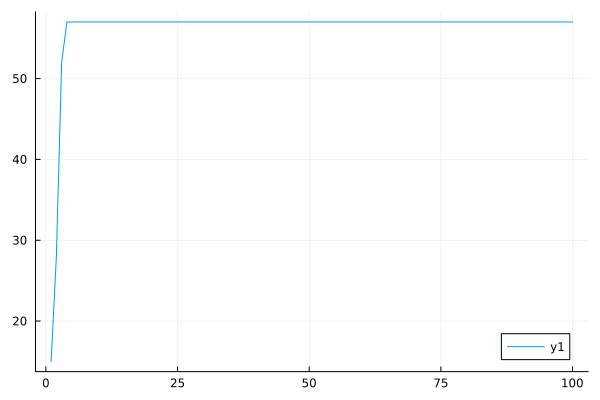

In [4]:
using Plots: plot, plot!
plot(1:100, map(i -> sum(map(x -> x != 0, P^i)), 1:100))


In [5]:
P^100

8×8 Matrix{Float64}:
 1.0        0.0         0.0         …  0.0        0.0        0.0
 0.0847652  0.00744022  0.00818492     0.0743351  0.0743351  0.669016
 0.0930246  0.00737308  0.00811105     0.0736643  0.0736643  0.662978
 0.0847652  0.00744022  0.00818492     0.0743351  0.0743351  0.669016
 0.175545   0.00670225  0.00737308     0.066962   0.066962   0.602658
 0.0847652  0.00744022  0.00818492  …  0.0743351  0.0743351  0.669016
 0.0930246  0.00737308  0.00811105     0.0736643  0.0736643  0.662978
 0.0847652  0.00744022  0.00818492     0.0743351  0.0743351  0.669016